# cGAN (Conditional GAN)

https://arxiv.org/pdf/1411.1784

https://github.com/eriklindernoren/Keras-GAN/tree/master/cgan

## 1. Import python libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchsummary import summary

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Set to model architecture & training process

In [ ]:
class cGAN():
    def __init__(self):

        # Setting input shape (MNIST image dimensions)
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.channels, self.img_rows, self.img_cols)

        # Define 10 classes for MNIST (digits 0-9)
        self.num_classes = 10

        # Dimension of the noise input
        self.latent_dim = 100

        # CUDA setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize Generator and Discriminator
        self.generator = self.build_generator().to(self.device)
        self.discriminator = self.build_discriminator().to(self.device)

        # Set optimizers for both generator and discriminator
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Define loss function
        self.criterion = nn.BCELoss() # BCE (binary cross-entropy) loss
        #self.criterion = nn.BCEWithLogitsLoss() # BCE with logits loss / improved training stability

        # Define an embedding layer that converts class labels into vectors
        self.label_embedding = nn.Embedding(self.num_classes, self.latent_dim).to(self.device)

        # Print model summaries
        print("Generator Model Summary:")
        summary(self.generator, input_size=(self.latent_dim *2,))

        print("Discriminator Model Summary:")
        summary(self.discriminator, input_size=(int(np.prod(self.img_shape)) + self.latent_dim,))

    # Build the Generator model
    def build_generator(self):
        model = nn.Sequential(
            nn.Linear(self.latent_dim * 2, 256), # latent_dim + label_embedding_dim
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256, momentum=0.8),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512, momentum=0.8),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024, momentum=0.8),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )
        return model

    # Build the Discriminator model
    def build_discriminator(self):
        model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)) + self.latent_dim, 512), # 784 (flattened image) + latent_dim (label embedding)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # for BCE loss
        )
        return model

    # Use this function to embed the labels into vectors
    def embed_labels(self, labels):
        return self.label_embedding(labels)

    # Training function
    def train(self, epochs=2000, batch_size=32, sample_interval=200):

        # Load MNIST dataset
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
        mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

        # Visualize noise-generated images before training
        print("Visualizing before training...")
        self.sample_images(0)

        for epoch in range(epochs):
            for i, (imgs, labels) in enumerate(dataloader):

                # Transfer real images and labels to the appropriate device (GPU or CPU)
                real_imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                # Define real and fake labels
                real = torch.ones((batch_size, 1)).to(self.device)
                fake = torch.zeros((batch_size, 1)).to(self.device)

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Generate noise and labels for fake images
                z = torch.randn((batch_size, self.latent_dim)).to(self.device)
                gen_labels = torch.randint(0, self.num_classes, (batch_size,)).to(self.device)

                # Generate fake images using the generator
                gen_input = torch.cat((z, self.embed_labels(gen_labels)), dim=1)
                gen_imgs = self.generator(gen_input)

                # Discriminator evaluation on real images
                real_input = torch.cat((real_imgs.view(real_imgs.size(0), -1), self.embed_labels(labels)), dim=1)
                d_real_loss = self.criterion(self.discriminator(real_input), real)

                # Discriminator evaluation on fake images
                fake_input = torch.cat((gen_imgs, self.embed_labels(gen_labels)), dim=1)
                d_fake_loss = self.criterion(self.discriminator(fake_input.detach()), fake)

                # Calculate total discriminator loss
                d_loss = (d_real_loss + d_fake_loss) / 2

                # Update discriminator
                self.optimizer_D.zero_grad()
                d_loss.backward()
                self.optimizer_D.step()

                # ---------------------
                #  Train Generator
                # ---------------------

                # Train generator to fool discriminator (make discriminator classify generated images as real)
                g_loss = self.criterion(self.discriminator(fake_input), real)

                # Update generator
                self.optimizer_G.zero_grad()
                g_loss.backward()
                self.optimizer_G.step()

            # Print loss every XXX epochs
            if (epoch+1) % sample_interval == 0:
                print(f"[Epoch {epoch+1}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
                self.sample_images(epoch+1)

    # Function to generate and save/display sampled images
    def sample_images(self, epoch):
        r, c = 2, 5
        z = torch.randn((r * c, self.latent_dim)).to(self.device)
        labels = torch.arange(0, self.num_classes).to(self.device)

        gen_input = torch.cat((z, self.embed_labels(labels)), dim=1)
        gen_imgs = self.generator(gen_input)

        gen_imgs = gen_imgs.view(gen_imgs.size(0), *self.img_shape)

        # Check if the "images" directory exists; if not, create it
        if not os.path.exists("images"):
            os.makedirs("images")

        # Save the generated images
        save_image(gen_imgs.data, f"images/{epoch}.png", nrow=c, normalize=True)

        # Display the generated images
        fig, axs = plt.subplots(r, c, figsize=(10, 4))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, 0].cpu().detach().numpy(), cmap='gray')
                axs[i, j].set_title(f"Digit: {labels[cnt].item()}")
                axs[i, j].axis('off')
                cnt += 1
        plt.show()

## Execute the training process

Generator Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          51,456
         LeakyReLU-2                  [-1, 256]               0
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 512]         131,584
         LeakyReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                 [-1, 1024]         525,312
         LeakyReLU-8                 [-1, 1024]               0
       BatchNorm1d-9                 [-1, 1024]           2,048
           Linear-10                  [-1, 784]         803,600
             Tanh-11                  [-1, 784]               0
Total params: 1,515,536
Trainable params: 1,515,536
Non-trainable params: 0
----------------------------------------------------------------
I

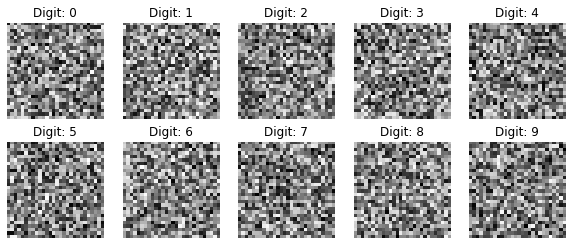

[Epoch 100/1000] [D loss: 0.3951661288738251] [G loss: 2.533519744873047]


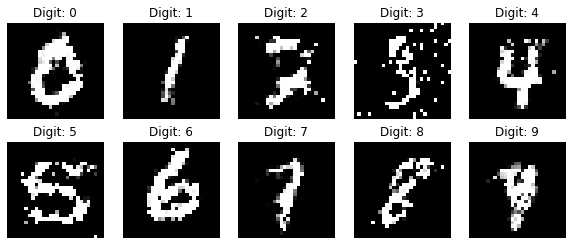

[Epoch 200/1000] [D loss: 0.2646779417991638] [G loss: 2.438483476638794]


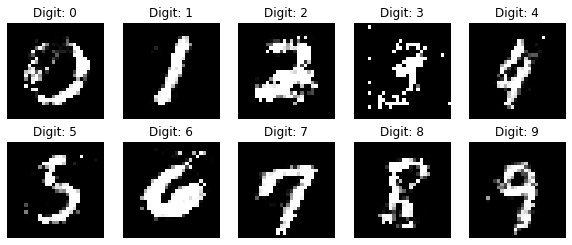

[Epoch 300/1000] [D loss: 0.44932714104652405] [G loss: 1.8966957330703735]


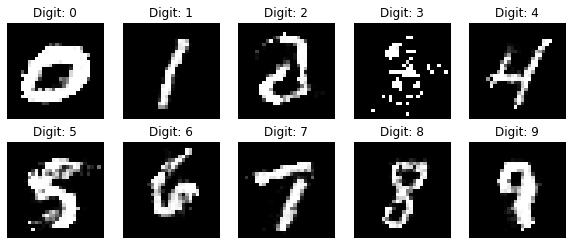

[Epoch 400/1000] [D loss: 0.23375770449638367] [G loss: 2.5982460975646973]


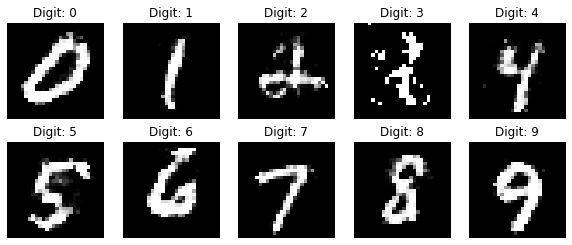

[Epoch 500/1000] [D loss: 0.4778014123439789] [G loss: 2.3872733116149902]


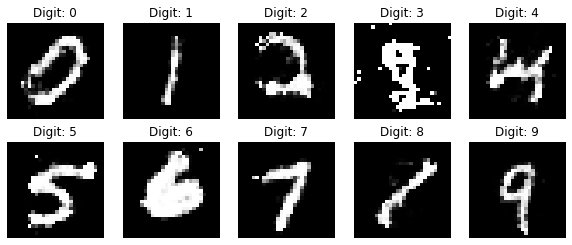

[Epoch 600/1000] [D loss: 0.2500358819961548] [G loss: 2.54999041557312]


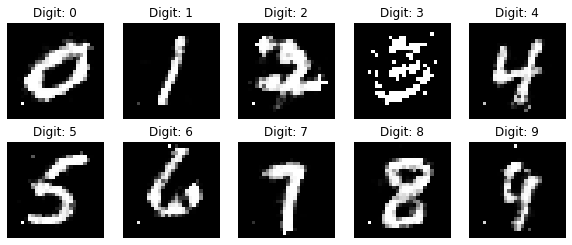

[Epoch 700/1000] [D loss: 0.3330412209033966] [G loss: 2.4194564819335938]


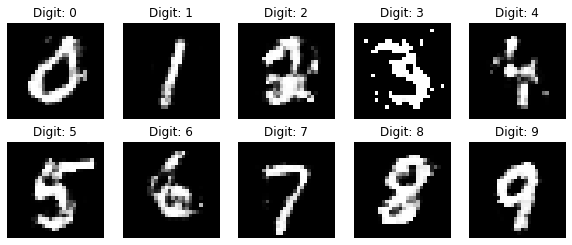

[Epoch 800/1000] [D loss: 0.2232762724161148] [G loss: 2.281721591949463]


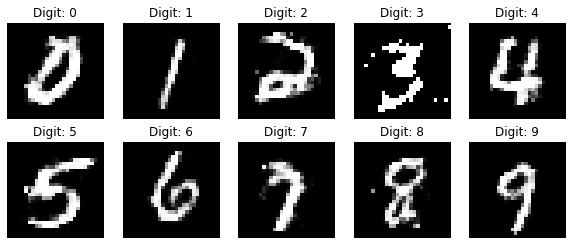

[Epoch 900/1000] [D loss: 0.29078519344329834] [G loss: 1.880470871925354]


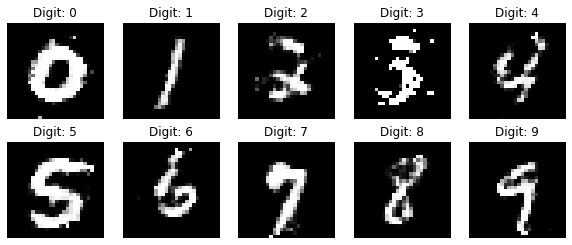

[Epoch 1000/1000] [D loss: 0.3306877017021179] [G loss: 1.9370423555374146]


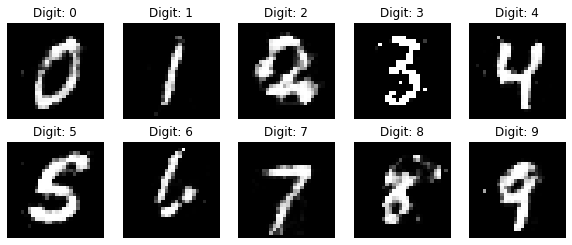

In [ ]:
# Run the cGAN
if __name__ == '__main__':

    gan = cGAN()
    gan.train(epochs=1000, batch_size=32, sample_interval=100)